In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests

sns.set_style('whitegrid')

In [3]:
arrest_data = requests.get('https://www.ethnicity-facts-figures.service.gov.uk/crime-justice-and-the-law/policing/number-of-arrests/latest/downloads/number-of-arrests.csv').content
arrest_df = pd.read_csv(io.StringIO(arrest_data.decode('utf-8')))
arrest_df = arrest_df.drop(columns=['Notes'])
arrest_df = arrest_df.dropna()
arrest_df = arrest_df[arrest_df['Age_Group'] == 'All']
arrest_df = arrest_df[arrest_df['Gender'] == 'All']

In [32]:
arrest_df.to_csv('arrest_df.csv')

In [29]:
def get_arrest_per_pop(location, df):
  df_new = df[df['Geography'] == location]
  df_new = df_new[df_new['Rate per 1,000 population by ethnicity, gender, and PFA'] != ' N/A ']
  df_new = df_new.pivot(index='Time', columns='Ethnicity' ,values='Rate per 1,000 population by ethnicity, gender, and PFA')
  df_new = df_new.convert_dtypes()
  df_new = df_new.apply(lambda x: x.str.replace(',', ''))
  df_new = df_new.astype(int)
  return df_new

In [30]:
arrest_df_all = get_arrest_per_pop('All', arrest_df)
arrest_df_cumbria = get_arrest_per_pop('Cumbria', arrest_df)
arrest_df_manchester = get_arrest_per_pop('Greater Manchester', arrest_df)

arrest_df_essex = get_arrest_per_pop('Essex', arrest_df)


In [8]:
arrest_df_suffolk

,All,Any other asian,Any other black background,Any other ethnic group,Any other mixed/multiple ethnic background,Any other white background,Asian,Bangladeshi,Black,Black African,Black Caribbean,Chinese,Indian,Mixed,Mixed White and Asian,Mixed White and Black African,Mixed White and Black Caribbean,Other,Pakistani,White,White British,White Irish
Time,,,,,,,,,,,,,,,,,,,,,,
2006/07,27,25,231,119,29,45,26,27,66,32,78,19,6,18,3,25,24,47,85,27,26,20
2007/08,23,13,108,42,34,90,12,14,31,24,14,3,2,24,16,32,23,14,35,23,22,24
2008/09,25,27,231,62,34,114,22,27,79,62,57,14,6,18,10,35,9,27,44,25,23,22
2009/10,22,17,277,73,32,98,23,47,98,67,99,7,11,19,17,25,8,26,41,22,20,21
2010/11,21,20,231,46,22,86,18,23,62,35,57,3,9,12,3,16,13,15,28,21,20,23
2011/12,19,21,262,42,47,65,19,27,62,32,50,2,6,21,3,38,15,13,38,19,18,17
2012/13,16,8,262,31,32,54,11,14,69,43,50,3,8,15,8,16,9,11,28,16,15,23
2013/14,15,15,108,18,25,46,14,23,59,51,57,6,8,15,9,25,11,9,19,15,14,9
2014/15,14,11,200,49,34,40,12,8,76,62,57,3,4,14,8,13,7,16,47,14,14,25


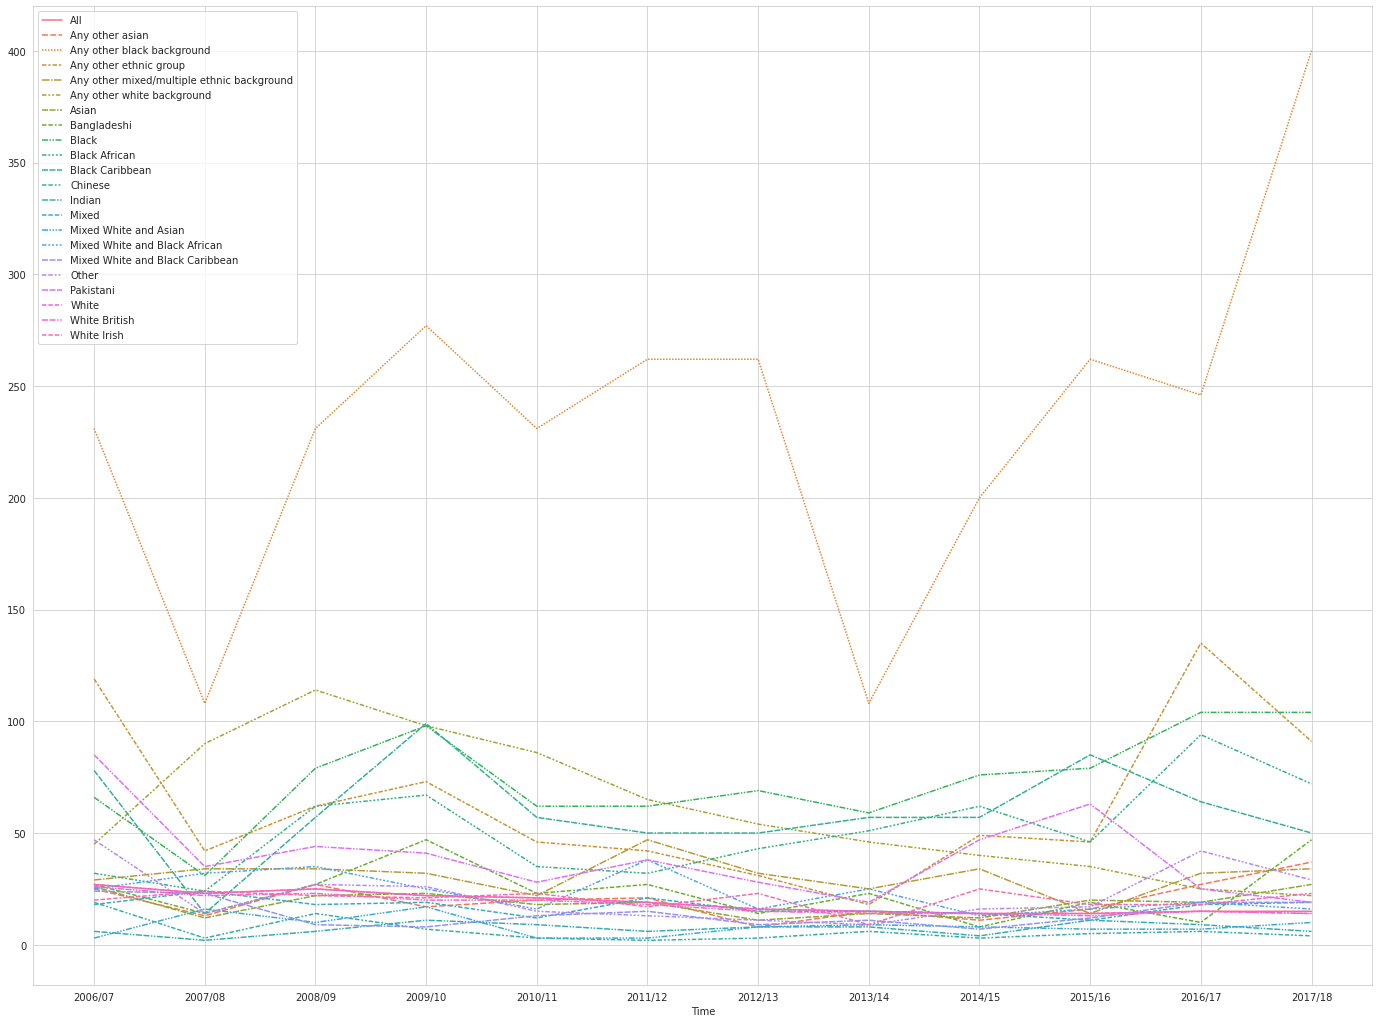

In [9]:
fig, ax = plt.subplots(figsize=(24,18))
sns.lineplot(data=arrest_df_suffolk)

Arrests in the UK by ethnicity by area across uk (city(urban area), small town/village(rural b area)) 

First use a classification method to classify what sort of area places are

get arrest data on a mix of different places from each category from different regions in the uk over a set period




How can you remove ai bias from an algorithm which is designed to find social bias?


Filter arrest data by all age, all genders

Unable to use london as an area of measurement due to there being alot of missing data in the dataset. I would merge this with another dataset to find the population per ethnicity of london but an dataset like this does not exist.
